# Laboratorio 2 - Visión por computadora

- Nelson García
- Joaquín Puente 
- Diego Linares

## TASK 2

Está desarrollando un sistema biométrico de seguridad. El sensor de huellas dactilares está sucio y
produce imágenes binarias con dos tipos de defectos:
1. Pequeños puntos blancos en los valles negros de la huella (Ruido Sal)
2. Las “crestas” de la huella tienen pequeñas roturas que impiden que el algoritmo de matching
funcione (grietas).

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("imgs/fingerprint_noisy.png", cv2.IMREAD_GRAYSCALE)

In [12]:
# que sea binaria
_, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

#  Apertura
kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
img_open = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_open)

# Cierre
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
img_final = cv2.morphologyEx(img_open, cv2.MORPH_CLOSE, kernel_close)


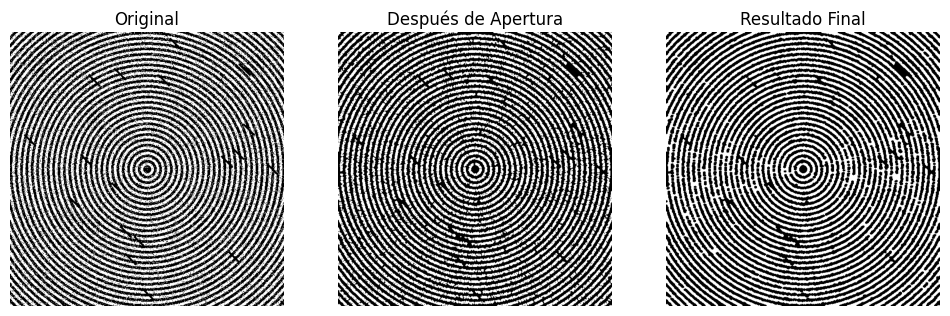

In [13]:

# Visualización
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_bin, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img_open, cmap='gray')
plt.title("Después de Apertura")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_final, cmap='gray')
plt.title("Resultado Final")
plt.axis("off")

plt.show()

#### ¿El orden de los factores altera el producto?

Si se aplica Cierre luego Apertura: el cierre engorda el ruido blanco luego la apertura no logra eliminarlo lo que nos daria como resultado crestas más gruesas, ruido todavía presente

Demostración visual (orden incorrecto)

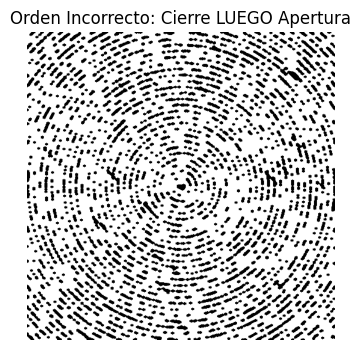

In [14]:
# Orden inverso (incorrecto)
img_close_first = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernel_close)
img_wrong = cv2.morphologyEx(img_close_first, cv2.MORPH_OPEN, kernel_open)

plt.figure(figsize=(6,4))
plt.imshow(img_wrong, cmap='gray')
plt.title("Orden Incorrecto: Cierre LUEGO Apertura")
plt.axis("off")
plt.show()


El orden importa porque cada operación modifica el dominio sobre el que actúa la siguiente.
Primero hay que eliminar ruido pequeño, luego reparar estructuras grandes. Hacerlo al revés amplifica el problema.

## Task 3 

Una fábrica textil necesita detectar rasgaduras en telas de mezclilla (denim) automáticamente. El problema
es que la tela tiene una textura natural fuerte (patrón repetitivo) que confunde a los detectores de bordes
simples (Canny), detectando el tejido como si fuera un defecto. Por ello se le pide que usted diseñe un
pipeline híbrido que combine Fourier y Morfología para aislar solamente la rasgadura. Para ello comienza
por probar su solución en una imagen que tiene a mano. Con esto en mente, realice:

In [15]:
# Importar librerías:

import argparse
import numpy as np
import cv2
import matplotlib.pyplot as plt

1. Utilice Fourier para analizar la textura repetitiva de la tela. Diseñe un filtro que elimine las
frecuencias altas/repetitivas del tejido, dejando una imagen "suavizada" donde solo resalte la
anomalía (la rasgadura) y la iluminación global. (Supresión de Textura)
a. Hint: ¿Qué pasa si eliminamos las frecuencias altas periféricas o específicas?

In [16]:
IMG_NAME = "imgs/textile_defect.jpg"

In [17]:
LOWPASS_SIGMA = 35       # más alto = más suavizado (menos textura)
NOTCH_PEAKS = 8          # cuántos picos de textura apagar
NOTCH_RADIUS = 10        # tamaño del "agujero" alrededor del pico


In [18]:
# --- Cargar imagen en gris ---
img = cv2.imread(IMG_NAME, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"No pude leer {IMG_NAME}. ¿Está en el mismo folder?")

h, w = img.shape
cy, cx = h // 2, w // 2

In [19]:
# --- FFT (pasar a frecuencia) ---
F = np.fft.fft2(img.astype(np.float32))
Fshift = np.fft.fftshift(F)

In [20]:
print(Fshift)

[[-46818.            +0.j         -15542.33301572-14124.78750201j
   -1315.12721094 +2560.60762885j ...  16163.51560603-12359.43977469j
   -1315.12721094 -2560.60762885j -15542.33301572+14124.78750201j]
 [-42763.93541324+45745.10837528j -20754.08147643+24393.74984037j
   27225.31842522-28475.4246797j  ... -29745.43140935-27209.1654095j
  -46741.97634692-17339.37126809j   -308.83341022  -997.4490809j ]
 [  7145.83479745-11420.68300755j  -1509.89676978-15950.87696814j
   15764.85616516+48837.1792555j  ... -24121.77428482+14740.92385776j
  -23631.66741234 +8009.36132344j -23949.03221674 -7855.8432153j ]
 ...
 [-25969.88750015 -3371.18199108j   9763.76121566+11495.74239994j
   19612.1890736  -2855.05516679j ... -37194.16065416 +3082.28925873j
    5075.51281436+24110.41806317j -58052.99224014+10967.88555532j]
 [  7145.83479745+11420.68300755j -23949.03221674 +7855.8432153j
  -23631.66741234 -8009.36132344j ...  17084.30767825 +8092.77494662j
   15764.85616516-48837.1792555j   -1509.89676978

In [21]:
# Magnitud (para visualizar el espectro y encontrar picos)
mag = np.log1p(np.abs(Fshift))

In [22]:
# --- Filtro 1: Low-pass gaussiano (quita altas frecuencias periféricas) ---
yy, xx = np.mgrid[0:h, 0:w]
dist2 = (yy - cy) ** 2 + (xx - cx) ** 2
lowpass = np.exp(-dist2 / (2.0 * (LOWPASS_SIGMA ** 2))).astype(np.float32)

# --- Filtro 2: Notch (apaga picos fuertes repetitivos del tejido) ---
mag2 = mag.copy()

In [23]:
# Quitar la zona central para no escoger "iluminación global" como pico
center_block = 25
mag2[cy - center_block:cy + center_block, cx - center_block:cx + center_block] = 0


In [24]:
# Elegir los picos más fuertes (aprox. patrones repetitivos)
flat = mag2.ravel()
idxs = np.argpartition(flat, -NOTCH_PEAKS)[-NOTCH_PEAKS:]
coords = np.column_stack(np.unravel_index(idxs, mag2.shape))


In [25]:
notch = np.ones((h, w), dtype=np.float32)
for y, x in coords:
    # Apaga un disco alrededor del pico y su simétrico (porque FFT de imagen real es simétrica)
    cv2.circle(notch, (int(x), int(y)), NOTCH_RADIUS, 0, -1)
    y2, x2 = int(2 * cy - y), int(2 * cx - x)
    if 0 <= y2 < h and 0 <= x2 < w:
        cv2.circle(notch, (x2, y2), NOTCH_RADIUS, 0, -1)

In [26]:
# --- Máscara final en frecuencia ---
freq_mask = lowpass * notch

# --- Aplicar filtro en frecuencia ---
F_filt = Fshift * freq_mask

# --- IFFT (volver al dominio espacial) ---
img_back = np.fft.ifft2(np.fft.ifftshift(F_filt))
img_back = np.real(img_back)

# Normalizar para visualizar bien
smooth = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


(-0.5, 511.5, 511.5, -0.5)

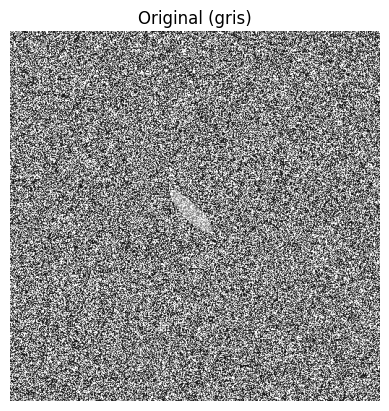

In [27]:
# --- Mostrar etapas ---
plt.figure()
plt.title("Original (gris)")
plt.imshow(img, cmap="gray")
plt.axis("off")



(-0.5, 511.5, 511.5, -0.5)

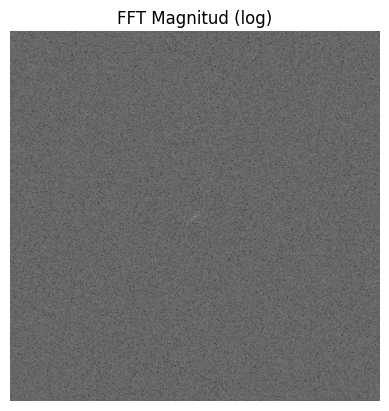

In [28]:
plt.figure()
plt.title("FFT Magnitud (log)")
plt.imshow(mag, cmap="gray")
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

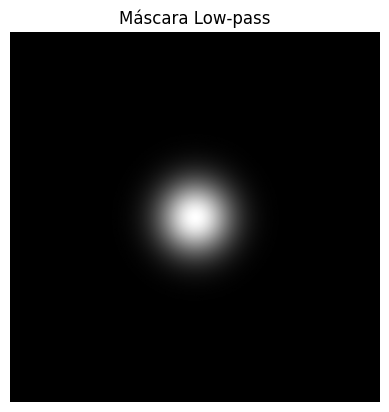

In [29]:
plt.figure()
plt.title("Máscara Low-pass")
plt.imshow(lowpass, cmap="gray")
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

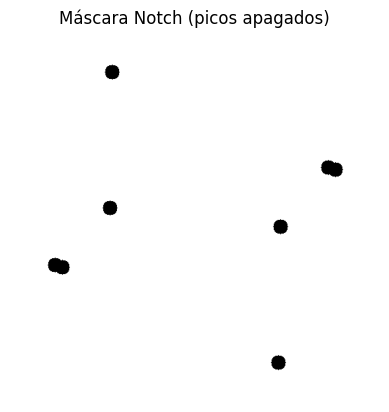

In [30]:
plt.figure()
plt.title("Máscara Notch (picos apagados)")
plt.imshow(notch, cmap="gray")
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

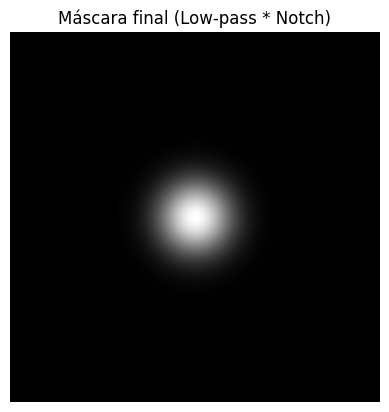

In [31]:
plt.figure()
plt.title("Máscara final (Low-pass * Notch)")
plt.imshow(freq_mask, cmap="gray")
plt.axis("off")


(-0.5, 511.5, 511.5, -0.5)

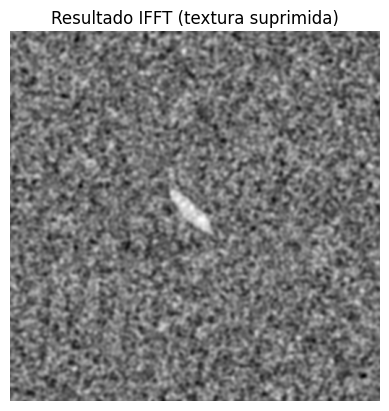

In [32]:
plt.figure()
plt.title("Resultado IFFT (textura suprimida)")
plt.imshow(smooth, cmap="gray")
plt.axis("off")

In [33]:
plt.show()

# Puntos Extras por Kahoot de la semana:

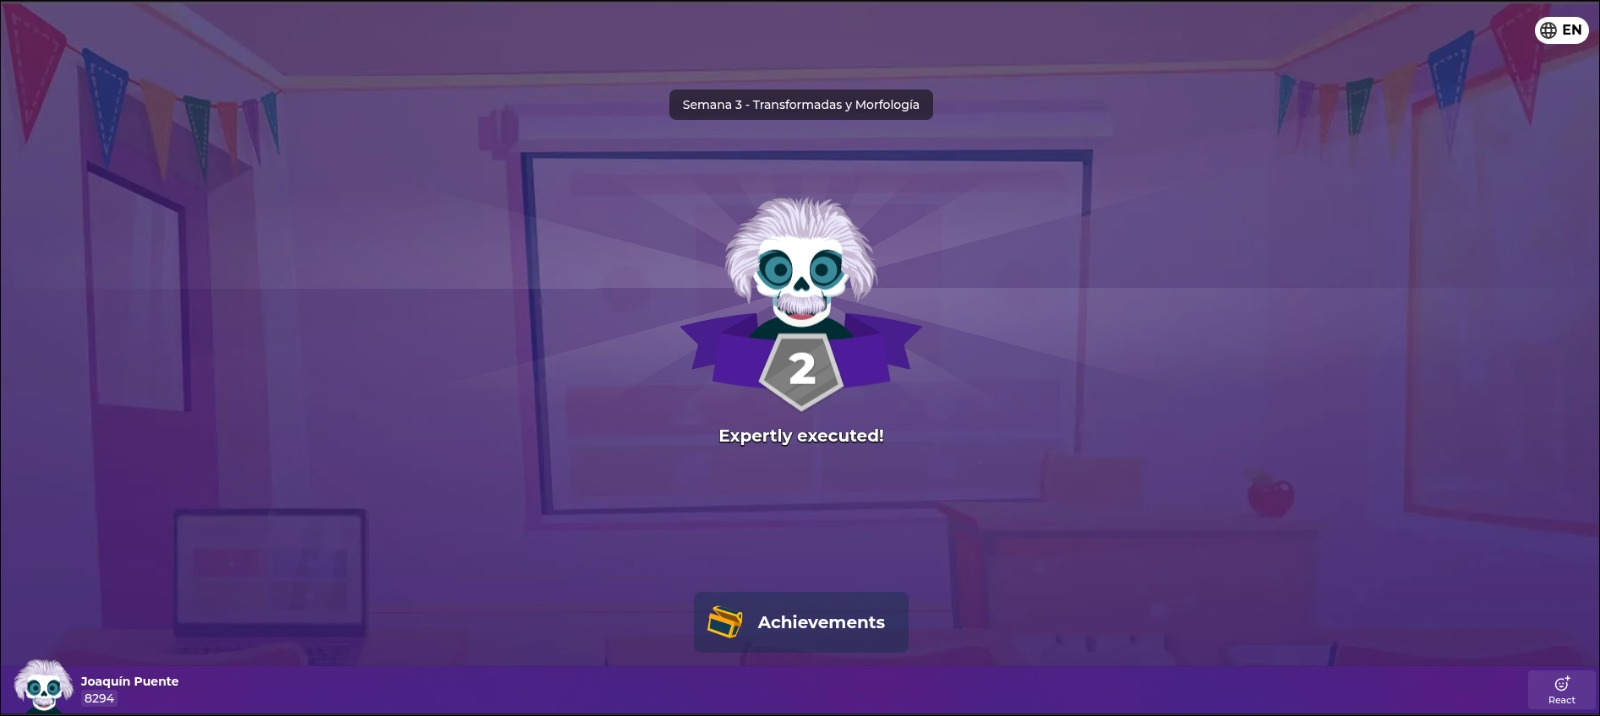



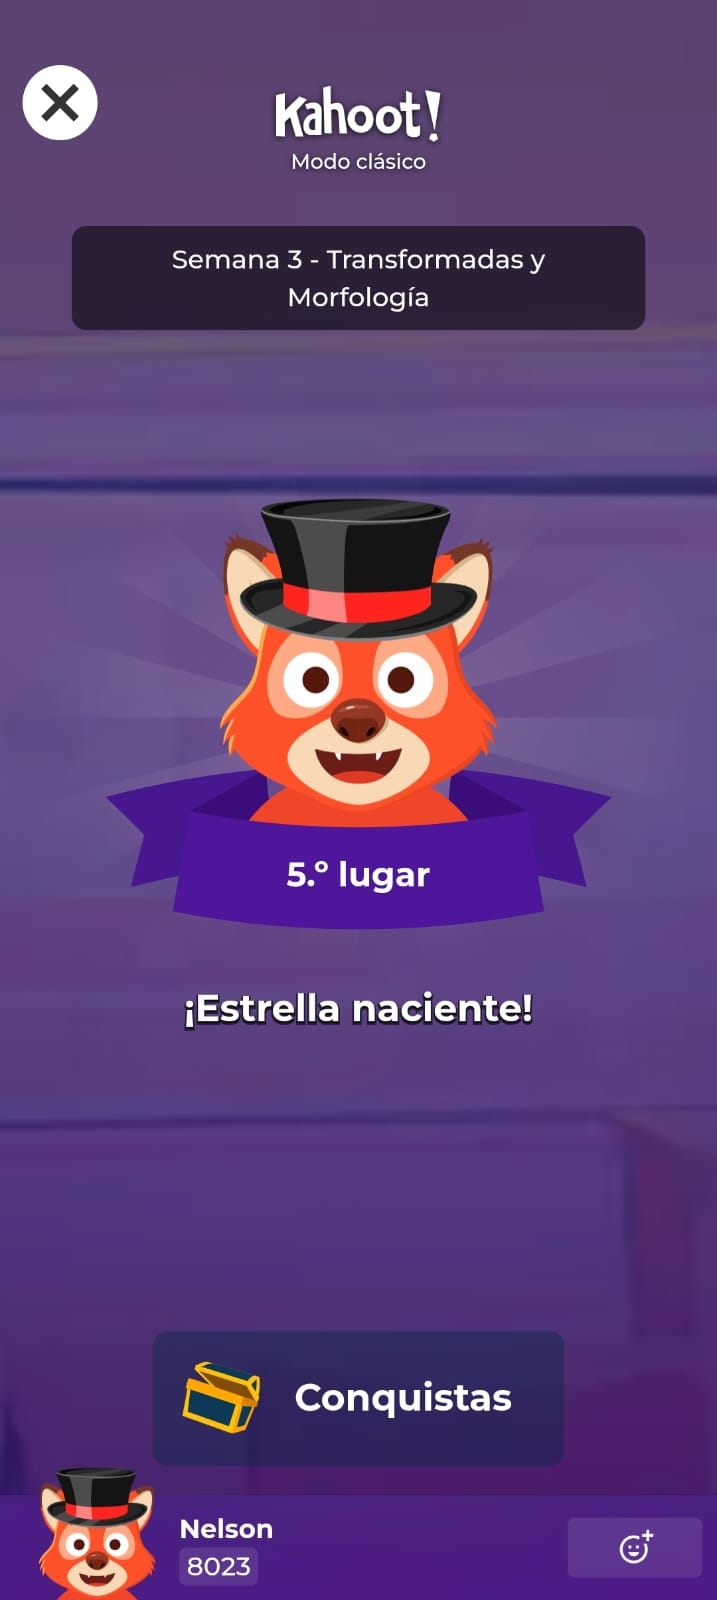